In [1]:
import pandas as pd
import numpy as np
from yahoo_fin.stock_info import get_data
import matplotlib.pyplot as plt

In [2]:
# get data from yahoo api
data_path = "../data/"
start_date= "01/01/2010"
end_date = "04/21/2024"

gc = get_data("GC=F", start_date = start_date, end_date = end_date, index_as_date = False,
     interval = "1d").set_index("date")
gc = gc[["close"]].rename(columns = {"close":"GC=F"})

vix = get_data("^vix", start_date = start_date, end_date = end_date, index_as_date = False,
     interval = "1d").set_index("date")
vix = vix[["close"]].rename(columns = {"close":"VIX"})

usd = get_data("DX-Y.NYB", start_date = start_date, end_date = end_date, index_as_date = False,
     interval = "1d").set_index("date")
usd = usd[["close"]].rename(columns = {"close":"USD"})

vix.to_csv(data_path + "VIX.csv", index = False)
gc.to_csv(data_path + "GCF.csv", index = False)
usd.to_csv(data_path + "USD.csv", index = False)

In [3]:
data = pd.concat([gc, vix, usd], axis = 1)
data = data[~((data["VIX"].isna()) & (data["USD"].isna()) & (data["GC=F"].isna()))].ffill()
data = data.dropna()
data

,GC=F,VIX,USD
date,,,
2010-01-04,1117.699951,20.040001,77.529999
2010-01-05,1118.099976,19.350000,77.620003
2010-01-06,1135.900024,19.160000,77.489998
2010-01-07,1133.099976,19.059999,77.910004
2010-01-08,1138.199951,18.129999,77.470001
...,...,...,...
2024-04-15,2365.800049,19.230000,106.209999
2024-04-16,2390.800049,18.400000,106.260002
2024-04-17,2371.699951,18.209999,105.949997


In [4]:
# calculate some returns and differences
data["log_ret_gc"] = np.log(data["GC=F"].pct_change()+1)
data["log_gc"] = np.log(data["GC=F"])
data["VIX_diff"] = data["VIX"].diff()
data["VIX_MA20"] = data["VIX"].rolling(20).mean()
data["VIX_pct"] = data["VIX"].pct_change()
data["USD_diff"] = data["USD"].diff()

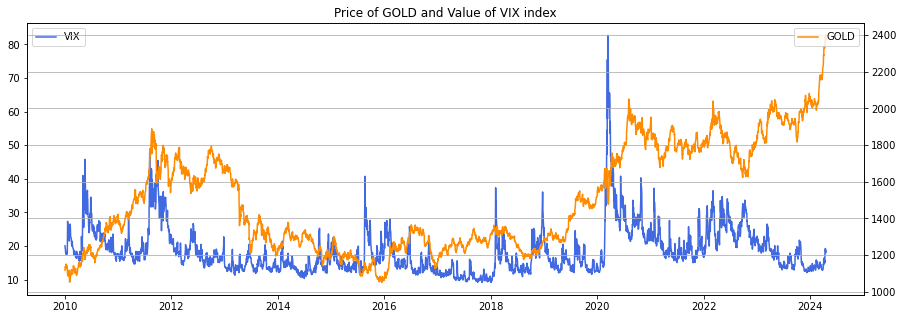

In [5]:
fig, ax1 = plt.subplots(1,1,figsize = (15,5))
ax1.plot(data["VIX"], color = "royalblue", label = "VIX")
ax2 = ax1.twinx()
ax2.plot(data["GC=F"],color = "darkorange", label = "GOLD")
plt.title("Price of GOLD and Value of VIX index")
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True)
plt.savefig("VIX_GOLD.png")
plt.show()

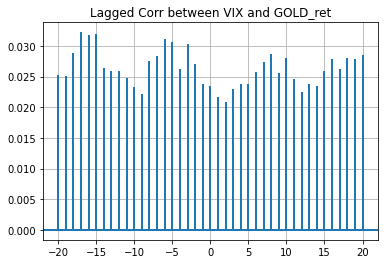

In [6]:
## plot correlation
y = data["log_ret_gc"][1:]
x = data["VIX"][1:]
plt.xcorr(x, y, usevlines=True, maxlags= 20, normed=True, lw=2)
plt.grid(True)
plt.title("Lagged Corr between VIX and GOLD_ret")
plt.savefig("VIX_GOLD_xcorr.png")
plt.show()

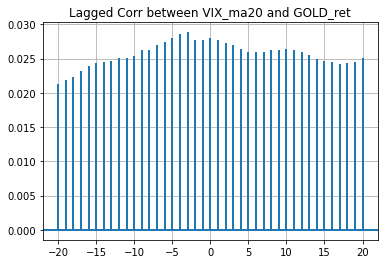

In [7]:
## plot correlation
y = data["log_ret_gc"][20:]
x = data["VIX_MA20"][20:]
plt.xcorr(x, y, usevlines=True, maxlags= 20, normed=True, lw=2)
plt.grid(True)
plt.title("Lagged Corr between VIX_ma20 and GOLD_ret")
plt.savefig("VIX_ma20_GOLD_xcorr.png")
plt.show()

In [8]:
data["VIX_MA20"].shift(1).corr(data["log_ret_gc"])

0.023190069937398066

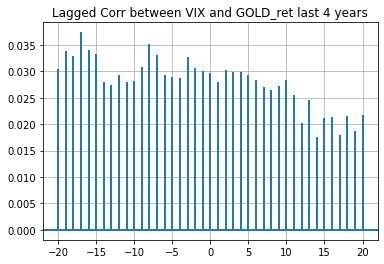

In [9]:
# the recent years: 
y = data["log_ret_gc"][-1000:]
x = data["VIX"][-1000:]
plt.xcorr(x, y, usevlines=True, maxlags= 20, normed=True, lw=2)
plt.grid(True)
plt.title("Lagged Corr between VIX and GOLD_ret last 4 years")
plt.savefig("VIX_GOLD_ret_xcorr_4years.png")
plt.show()

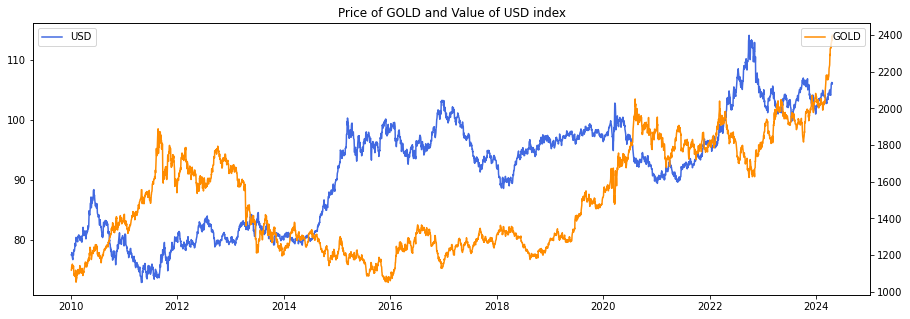

In [10]:
fig, ax1 = plt.subplots(1,1,figsize = (15,5))
ax1.plot(data["USD"], color = "royalblue", label = "USD")
ax2 = ax1.twinx()
ax2.plot(data["GC=F"],color = "darkorange", label = "GOLD")
plt.title("Price of GOLD and Value of USD index")
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.savefig("USD_GOLD.png")
plt.show()

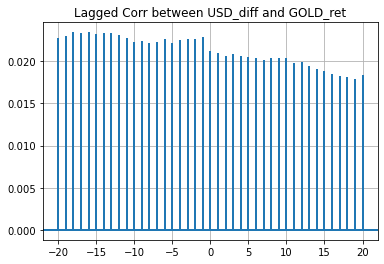

In [11]:
## plot correlation
y = data["log_ret_gc"][1:]
x = data["USD"][1:]
plt.xcorr(x, y, usevlines=True, maxlags= 20, normed=True, lw=2)
plt.grid(True)
plt.title("Lagged Corr between USD_diff and GOLD_ret")
plt.savefig("USD_GOLD_xcorr.png")
plt.show()

In [12]:
# try google trends factor
google_trends_monthly = pd.read_csv('../data/google_trends.csv')
google_trends_monthly = google_trends_monthly.iloc[1:]
google_trends_monthly = google_trends_monthly.rename(columns={"类别：所有类别":"war_report"})

In [13]:
gold_month = data[["GC=F"]]
gold_month = gold_month.resample("M").last()
gold_month_ret = gold_month[:-1].pct_change()
google_trends_monthly.index = pd.to_datetime(google_trends_monthly.index)
gold_month_ret.index = google_trends_monthly.index[:-1]
google_trends_monthly["war_report"] = google_trends_monthly["war_report"].astype(float)

In [14]:
gold_month_ret["GC=F"].corr(google_trends_monthly["war_report"].shift(1)[1:])

0.013112986266259785

In [15]:
google_trends_daily = pd.read_csv('../data/google_trends_recent_day.csv')
google_trends_daily = google_trends_daily.iloc[1:]
google_trends_daily = google_trends_daily.rename(columns={"类别：所有类别":"war_report"})
google_trends_daily.index = pd.to_datetime(google_trends_daily.index)
google_trends_daily["war_report"] = google_trends_daily["war_report"].astype(float)

In [16]:
new_test = google_trends_daily.join(data["log_ret_gc"]).dropna()
new_test["war_report"].shift(1).corr(new_test["log_ret_gc"])

0.1553594515513935

In [17]:
(new_test["war_report"]-new_test["war_report"].rolling(20).mean()).shift(1).corr(new_test["log_ret_gc"])

0.11790607410827053